In [1]:
import os 
import numpy as np
import pandas as pd
import pickle 
from astropy.table import Table

In [2]:
import sklearn
print(sklearn.__version__)

1.0.2


In [3]:
train_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_HEAD.FITS'
train_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_PHOT.FITS'
test_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/test_final_master_HEAD.FITS'
test_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/test_final_master_PHOT.FITS'

In [4]:
df_header = Table.read(train_data_head_path, format='fits').to_pandas()
df_phot = Table.read(train_data_phot_path, format='fits').to_pandas()

In [5]:
from kndetect.utils import load_pcs, get_event_type, get_data_dir_path
from kndetect.features import extract_features_all_lightcurves
from kndetect.training import append_y_true_col

In [6]:
pcs = load_pcs()
data_dir = get_data_dir_path()

In [7]:
use_already_trained_features = False
use_already_trained_models = False
mimic_alerts = True
save_data = True

if mimic_alerts:
    sub_directory = "partial"
else: 
    sub_directory = "complete"

In [8]:
if use_already_trained_features:
    train_features_df = pd.read_csv(os.path.join(data_dir, sub_directory, "train_features.csv"),index_col=0)

else:
    train_features_df = extract_features_all_lightcurves(df_phot, 
                                                         "SNID", 
                                                         pcs, 
                                                         [b'g', b'r'],
                                                         mimic_alerts=mimic_alerts)
    train_features_df = append_y_true_col(features_df=train_features_df,
                                          prediction_type_nos=[149, 150, 151],
                                          meta_df = df_header, 
                                          meta_key_col_name = "SNID",
                                          meta_type_col_name = "SNTYPE")

100%|██████████| 22280/22280 [06:49<00:00, 54.38it/s]


In [9]:
train_features_df

,coeff1_g,coeff2_g,coeff3_g,residuo_g,maxflux_g,coeff1_r,coeff2_r,coeff3_r,residuo_r,maxflux_r,key,current_dates,type,type_names,y_true
0,0.0,0.000000,0.000000,0.000000,0.000000,2.0,0.069571,-0.004633,1.625710,373.748047,1757,57661.2481,150,150: KN GW170817,True
1,2.0,0.066558,-0.005834,2.707710,427.853790,2.0,0.071780,0.093859,6.561144,788.683228,6415,57454.4909,141,141: 91BG,False
2,2.0,0.101134,0.235519,2.888930,270.629425,2.0,0.043898,-0.015312,6.294424,518.246521,7707,57490.1773,103,103: Core collapse Type Ibc,False
3,0.0,0.000000,0.000000,0.000000,0.000000,2.0,0.067123,-0.005580,1.069312,239.701599,8267,57668.3579,151,151: KN Karsen 2017,True
4,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,12578,57517.4403,102,102: MOSFIT-Ibc,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22275,2.0,0.054105,-0.010143,7.934632,888.318420,2.0,0.074466,0.192838,4.551304,666.974243,137062467,57492.3009,112,112: Core collapse Type II,False
22276,2.0,0.030188,0.028718,8.510762,1141.677979,2.0,0.022529,0.008462,9.088945,1213.934937,137071784,57660.5094,170,170: AGN,False
22277,2.0,0.099434,0.232693,3.966065,295.870941,2.0,0.041992,0.007248,5.159031,408.148193,137071978,57614.2995,143,143: Iax,False
22278,2.0,0.066114,-0.012144,1.344058,525.301697,2.0,-0.003614,-0.035132,4.019346,445.314880,137079473,57496.2954,151,151: KN Karsen 2017,True


# Now Train the classifier

In [10]:
from kndetect.training import train_classifier

In [11]:
if not use_already_trained_models:
    clf, features_df = train_classifier(train_features_df)
    if save_data:
        with open(os.path.join(data_dir, "models", sub_directory + ".pkl"), 'wb') as files:
            pickle.dump(clf, files)
else:
    from kndetect.predict import load_classifier
    clf = load_classifier(sub_directory + ".pkl")

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/kndetect/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/kndetect/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [12]:
# Generate Test features and Predict probabilities

In [13]:
df_header_test = Table.read(test_data_head_path, format='fits').to_pandas()
df_phot_test = Table.read(test_data_phot_path, format='fits').to_pandas()

In [14]:
if use_already_trained_features:
    test_features_df = pd.read_csv(os.path.join(data_dir, sub_directory, "test_features.csv"),index_col=0)

else:
    test_features_df = extract_features_all_lightcurves(df_phot_test, 
                                                         "SNID", 
                                                         pcs, 
                                                         [b'g', b'r'],
                                                         mimic_alerts=mimic_alerts)
    test_features_df = append_y_true_col(features_df=test_features_df,
                                          prediction_type_nos=[149, 150, 151],
                                          meta_df = df_header_test, 
                                          meta_key_col_name = "SNID",
                                          meta_type_col_name = "SNTYPE")

100%|██████████| 21288/21288 [06:28<00:00, 54.76it/s]


In [15]:
from kndetect.predict import load_classifier, predict_kn_score

In [16]:
probabilities, filtered_indices = predict_kn_score(clf, test_features_df)

In [17]:
test_features_df['y_pred_score'] = probabilities.T[1]

In [18]:
filtered=test_features_df[filtered_indices]

In [19]:
y_true = filtered["y_true"] == 1
y_pred = filtered["y_pred_score"]>0.5

In [20]:
y_true_train = features_df["y_true"]
y_pred_train = features_df["y_pred"]

print("train statistics:")
print("\ntotal number of events: " + str(len(y_true_train)))
print("total number of KN: " + str(np.sum(y_true_train)))
print("total number of non KN: " + str(np.sum(~y_true_train))) 

print("\nTrue Positive : {tp}".format(tp = np.sum(y_true_train&y_pred_train)))
print("False Positive : {fp}".format(fp = np.sum(~y_true_train&y_pred_train)))
print("True negative : {tn}".format(tn = np.sum(~y_true_train&~y_pred_train)))
print("False negative : {fn}".format(fn = np.sum(y_true_train&~y_pred_train)))


train statistics:

total number of events: 22280
total number of KN: 3280
total number of non KN: 19000

True Positive : 1990
False Positive : 232
True negative : 18768
False negative : 1290


In [21]:
features_df[features_df["type"]==151]

,coeff1_g,coeff2_g,coeff3_g,residuo_g,maxflux_g,coeff1_r,coeff2_r,coeff3_r,residuo_r,maxflux_r,key,current_dates,type,type_names,y_true,y_pred,y_score
3,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,0.067123,-0.005580,1.069312,239.701599,8267,57668.3579,151,151: KN Karsen 2017,True,False,0.426654
10,2.0,0.066950,-0.005736,6.516082,1721.492798,2.000000,0.067735,0.010370,5.561417,1562.443726,22525,57490.2165,151,151: KN Karsen 2017,True,True,0.799883
33,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,0.077010,0.101645,3.899499,787.250732,116775,57693.1267,151,151: KN Karsen 2017,True,False,0.459254
51,2.0,0.064380,-0.018013,1.671283,408.353363,2.000000,0.076239,0.045184,2.057823,289.400940,207459,57473.3759,151,151: KN Karsen 2017,True,True,0.689025
58,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,231140,57630.3144,151,151: KN Karsen 2017,True,False,0.169780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22253,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,136959425,57629.2702,151,151: KN Karsen 2017,True,False,0.169780
22255,2.0,0.083712,0.001325,1.153927,211.880478,0.000000,0.000000,0.000000,0.000000,0.000000,136970486,57620.4006,151,151: KN Karsen 2017,True,False,0.310901
22258,2.0,0.066370,-0.005808,2.207901,471.565826,0.000000,0.000000,0.000000,0.000000,0.000000,136976627,57653.2097,151,151: KN Karsen 2017,True,True,0.569443
22273,0.0,0.000000,0.000000,0.000000,0.000000,0.949705,-0.023464,-0.512078,1.028187,246.065933,137057324,57615.3977,151,151: KN Karsen 2017,True,False,0.451126


In [22]:
print("test statistics:")
print("\ntotal number of events: " + str(len(y_true)))
print("total number of KN: " + str(np.sum(y_true)))
print("total number of non KN: " + str(np.sum(~y_true))) 

print("\nTrue Positive : {tp}".format(tp = np.sum(y_true&y_pred)))
print("False Positive : {fp}".format(fp = np.sum(~y_true&y_pred)))
print("True negative : {tn}".format(tn = np.sum(~y_true&~y_pred)))
print("False negative : {fn}".format(fn = np.sum(y_true&~y_pred)))

test statistics:

total number of events: 11052
total number of KN: 897
total number of non KN: 10155

True Positive : 538
False Positive : 216
True negative : 9939
False negative : 359


In [23]:
if save_data:
    train_features_df.to_csv(os.path.join(data_dir, sub_directory, "train_features.csv"))
    test_features_df.to_csv(os.path.join(data_dir, sub_directory, "test_features.csv"))

[[0.89929425 0.01954397]
 [0.03248281 0.04867897]]


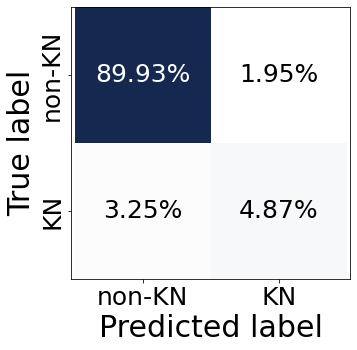

In [24]:
from kndetect.plot_lightcurve import plot_confusion_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
plot_confusion_matrix(ax, y_true, y_pred)

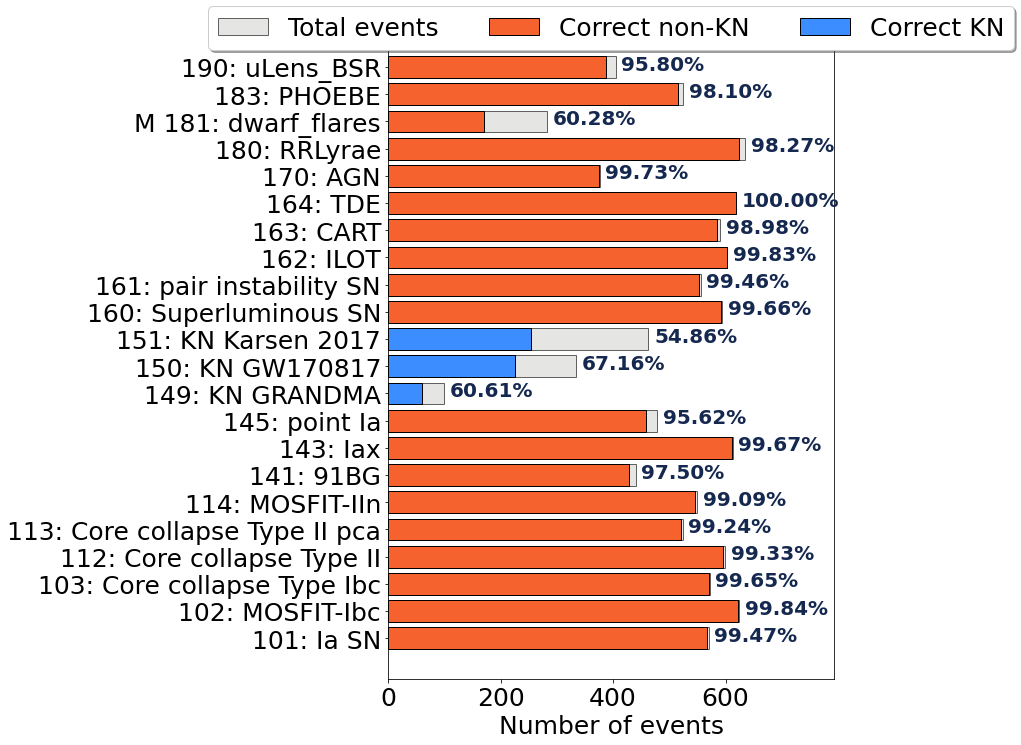

In [25]:
from kndetect.plot_lightcurve import plot_contamination_statistics
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,12))
ax = plt.gca()
plot_contamination_statistics(ax, filtered, [149,150,151])